In [2]:
import numpy as np
import matplotlib.pyplot as plt

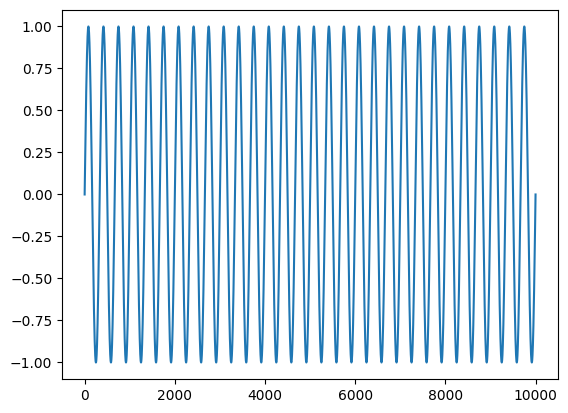

In [21]:
A = 1.0
f = 300.0 # Hz
t = np.linspace(0.0, 10000.0, 100_000) # in seconds
phi = 0.0

yt = A * np.sin(2.*np.pi*f*t + phi)
plt.plot(t, yt)